In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

Next steps

Hi Rongjun, thanks for chat just now. Here a summary of what we agreed as the next steps. The plan is to proceed two fronts in parallel.  
 
1) Determining SFR and metallicities for IC 3392
Download the gas emission line data product for IC 3392 from this link https://mauve.wiki.org.au/MAUVE-MUSE/DataAccess/nGIST_v2
Construct a Balmer Decrement map. As discussed, while the map will have a value for each spaxel, not all of them are good fits, so try to gauge how to deal with this starting, perhaps, from a flux/error ratio of 5 for all lines. But you may need a harsher cut. 
For "fun", compare your map with the E(B-V) map of the stars. 
Create a BPT map (using both version of the BP using both [NII] and [SII]) and identify the spaxels where photoionisation is consistent with SF. 
Then, create a SFR map where you first correct the Halpha for extinction and then convert into SFR only for the spaxels that are photoionised by SF.
 
2) Determine a stellar mass map for another galaxy 
       In parallel, test your stellar mass determination on another galaxy. I suggest you use NGC4501. On CANFAR under /arc/projects/mauve/products/v0.6/NGC4501/ you will find all the files you need: i.e., the weights and the SFH map where the EB-V is stored.  For no reason modify these files, but create a copy on your own working space on CANFAR.  It is very important that every time you use a data product you copy your own version. 
 
I think this is it. Enjoy the long weekend!
 

In [2]:
# Load E(B-V) map from IC3392_SFH_maps.fits
SFH_path = Path('IC3392_SFH_maps.fits')
print(f"Loading SFH map from {SFH_path}")
with fits.open(SFH_path) as hdul:
    EBV = hdul['EBV'].data
    EBV_header = hdul['EBV'].header

EBV_header

Loading SFH map from IC3392_SFH_maps.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

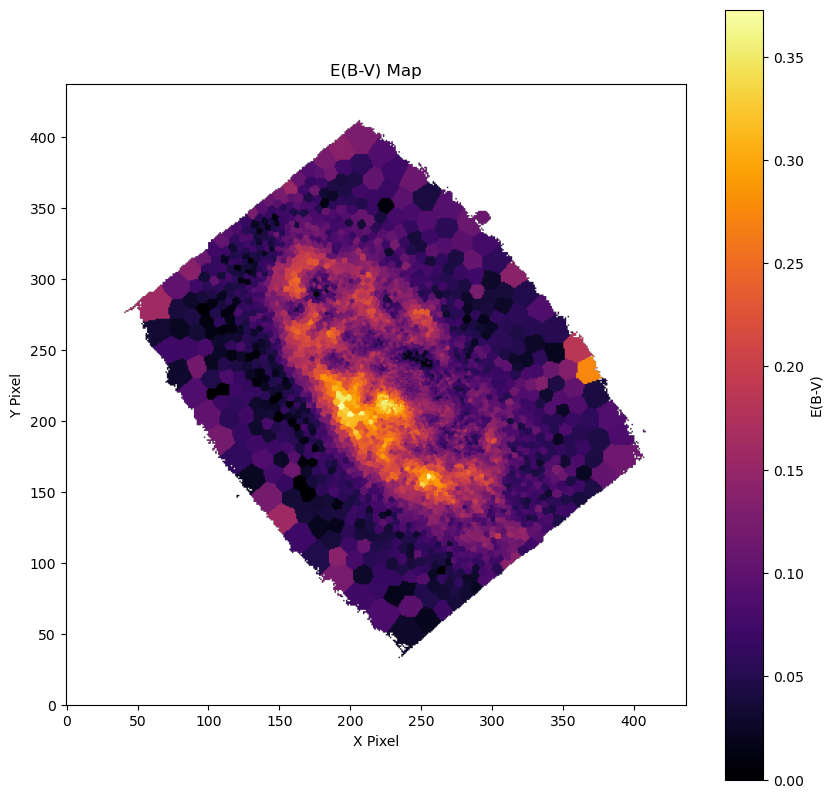

In [3]:
# plot the E(B-V) map
plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(EBV, origin='lower', cmap='inferno')
plt.colorbar(label='E(B-V)')
plt.title('E(B-V) Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [4]:
# Load gas line map IC3392_gas_BIN_maps.fits 
gas_path = Path('IC3392_gas_BIN_maps.fits')
print(f"Loading gas line map from {gas_path}")
with fits.open(gas_path) as hdul:
    HB4861_FLUX = hdul['HB4861_FLUX'].data
    HB4861_FLUX_ERR = hdul['HB4861_FLUX_ERR'].data
    HA6562_FLUX = hdul['HA6562_FLUX'].data
    HA6562_FLUX_ERR = hdul['HA6562_FLUX_ERR'].data
    OIII5006_FLUX = hdul['OIII5006_FLUX'].data
    OIII5006_FLUX_ERR = hdul['OIII5006_FLUX_ERR'].data
    NII6583_FLUX = hdul['NII6583_FLUX'].data
    NII6583_FLUX_ERR = hdul['NII6583_FLUX_ERR'].data
    SII6716_FLUX = hdul['SII6716_FLUX'].data
    SII6716_FLUX_ERR = hdul['SII6716_FLUX_ERR'].data
    SII6730_FLUX = hdul['SII6730_FLUX'].data
    SII6730_FLUX_ERR = hdul['SII6730_FLUX_ERR'].data
    gas_header = hdul[5].header
    hdul.close()

gas_header

Loading gas line map from IC3392_gas_BIN_maps.fits


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

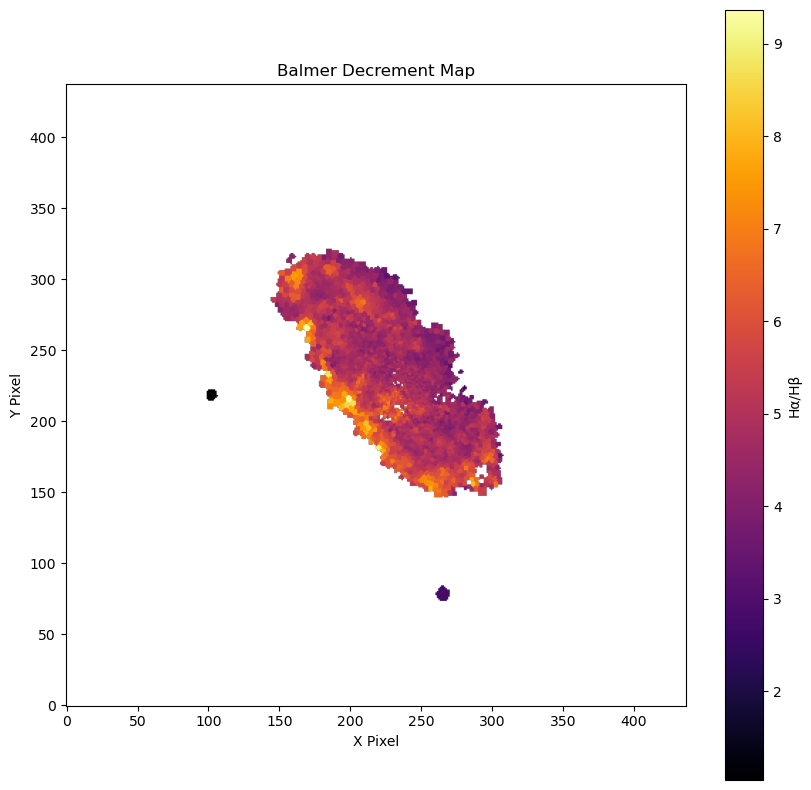

Lowest Balmer Decrement: 1.0401808450211778
Highest Balmer Decrement: 9.36650837704988
Lowest 5 unique non-NaN Balmer Decrement values: [1.04018085 2.65574445 2.82774723 3.09627082 3.22428465]


In [5]:
# Apply a first cut of FLUX/ERR ≥ 5 on every line, 
# at least 22 to get min BD>2.86
# at least 15 to have all SF in BPT diagram
cut = 15
mask_HB = HB4861_FLUX / HB4861_FLUX_ERR >= cut
mask_HA = HA6562_FLUX / HA6562_FLUX_ERR >= cut
# Combine masks for both lines
mask_combined = mask_HB & mask_HA
# Apply the mask to the flux maps
HB4861_FLUX_cut = np.where(mask_combined, HB4861_FLUX, np.nan)
HA6562_FLUX_cut = np.where(mask_combined, HA6562_FLUX, np.nan)

# Balmer-decrement map – H α/H β (start with all spaxels).
BD = HA6562_FLUX_cut / HB4861_FLUX_cut

plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(BD, origin='lower', cmap='inferno')
plt.colorbar(label='Hα/Hβ')
plt.title('Balmer Decrement Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Print the lowest and highest values of the Balmer decrement map
print(f"Lowest Balmer Decrement: {np.nanmin(BD)}")
print(f"Highest Balmer Decrement: {np.nanmax(BD)}")
# Print lowest 5 non-NaN values (unique values only)
bd_valid = BD[~np.isnan(BD)]
bd_unique = np.unique(bd_valid)
lowest_5_unique = bd_unique[:5]
print(f"Lowest 5 unique non-NaN Balmer Decrement values: {lowest_5_unique}")


In [6]:
out_path = Path('IC3392_gas_BIN_maps_extended.fits')

# 1) read the whole HDUList from disk
with fits.open(gas_path) as hdul:
    # 2) clone all existing HDUs into a new list
    new_hdul = fits.HDUList([hdu.copy() for hdu in hdul])

# 3) build the new Balmer Decrement image HDU
BD_hdu = fits.ImageHDU(
    data=BD.astype(np.float64), name="Balmer_Decrement",)

# 4) keep WCS and pixel-scale info by copying the original BINID header
BD_hdu.header.update(gas_header)         # you created gas_hdr earlier
BD_hdu.header["EXTNAME"] = "Balmer_Decrement"
BD_hdu.header["BUNIT"]   = ""  # physical units

# 5) append and write to disk
new_hdul.append(BD_hdu)
new_hdul.writeto(out_path, overwrite=True)

print(f"Saved extended file to {out_path.resolve()}")

Saved extended file to /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_gas_BIN_maps_extended.fits


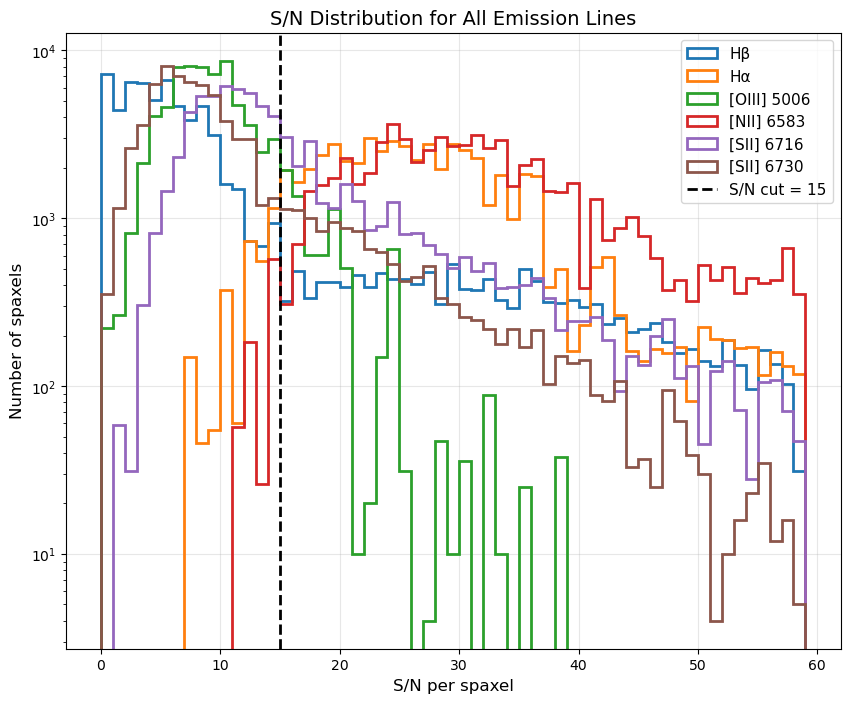

In [7]:
plt.figure(figsize=(10, 8))

for i, (line, flux, err) in enumerate([('Hβ', HB4861_FLUX, HB4861_FLUX_ERR),
                                      ('Hα', HA6562_FLUX, HA6562_FLUX_ERR), 
                                      ('[OIII] 5006', OIII5006_FLUX, OIII5006_FLUX_ERR),
                                      ('[NII] 6583', NII6583_FLUX, NII6583_FLUX_ERR),
                                      ('[SII] 6716', SII6716_FLUX, SII6716_FLUX_ERR),
                                      ('[SII] 6730', SII6730_FLUX, SII6730_FLUX_ERR)]):
    sn = flux/err
    plt.hist(sn[np.isfinite(sn)].ravel(), bins=np.arange(0,60,1), histtype='step', 
             label=line, linewidth=2)

plt.axvline(cut, ls='--', color='k', linewidth=2, label=f'S/N cut = {cut}')
plt.yscale('log')
plt.xlabel('S/N per spaxel', fontsize=12)
plt.ylabel('Number of spaxels', fontsize=12)
plt.title('S/N Distribution for All Emission Lines', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.show()


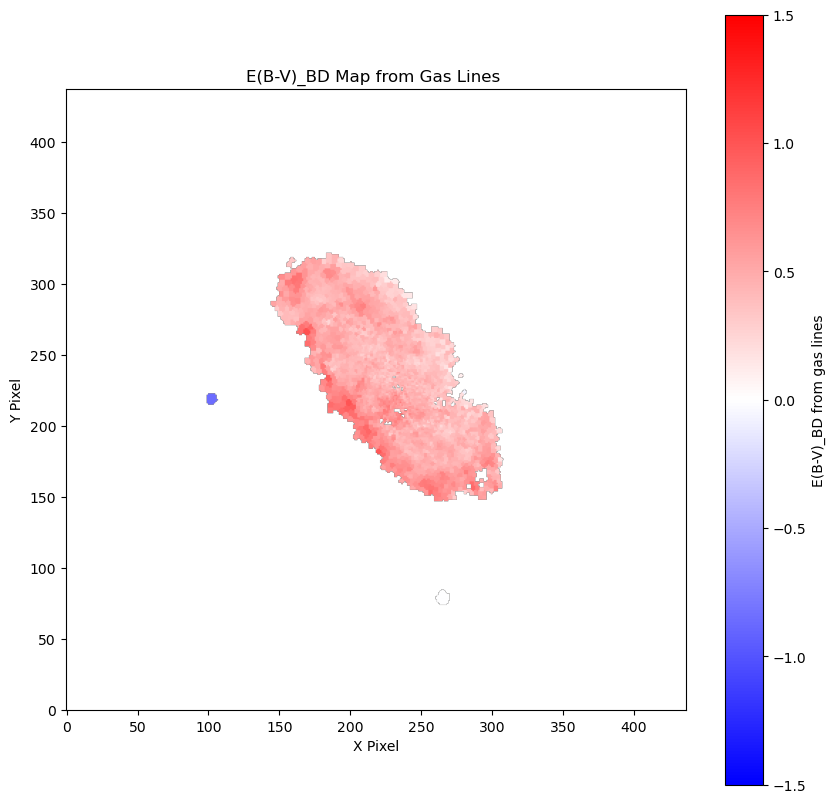

In [8]:
# O'Donnell (1994) update
# k_Hb = 3.609   # 4861 Å
# k_Ha = 2.535   # 6563 Å
# Cardelli (2000)
k_Hb = 4.598 
k_Ha = 3.325
R_int = 2.86

E_BV_BD = 2.5/(k_Hb - k_Ha) * np.log10( (HA6562_FLUX_cut/HB4861_FLUX_cut) / R_int )

plt.figure(figsize=(10, 10))
# plt.style.use('dark_background')
plt.imshow(E_BV_BD, origin='lower', cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(label='E(B-V)_BD from gas lines')
plt.title('E(B-V)_BD Map from Gas Lines ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [9]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   gas_header    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    E_BV_BD_hdu = fits.ImageHDU(
        data=E_BV_BD.astype(np.float64),  # like others
        header=gas_header, name="E(B-V)_BD")  # new HDU name
    E_BV_BD_hdu.header["BUNIT"] = ""  # units keyword
    hdul.append(E_BV_BD_hdu)                                    # add as new HDU 
    hdul.flush()                                             # write in-place
print("E(B-V)_BD layer saved ➜", out_path.resolve())

E(B-V)_BD layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_gas_BIN_maps_extended.fits


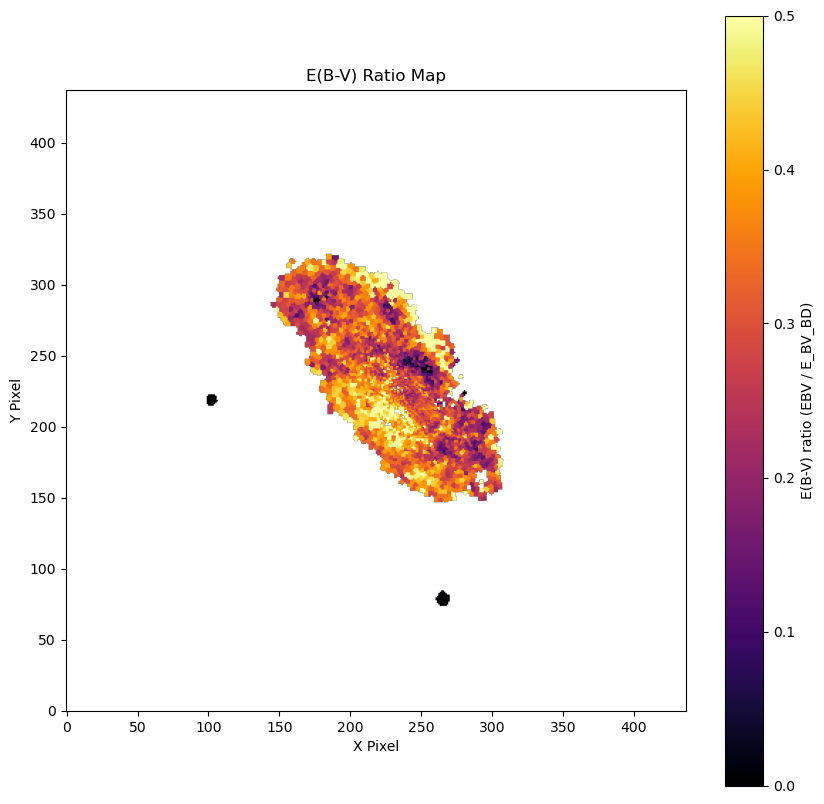

Lowest E(B-V) ratio: -3.3583870320988307
Highest E(B-V) ratio: 1.2103164712174959
Mean E(B-V) ratio: 0.3158958661204729
Median E(B-V) ratio: 0.3239813378099946
Standard Deviation E(B-V) ratio: 0.293863940362878


In [10]:
# Plot the E(B-V) from gas lines map over the E(B-V) map
E_BV_ratio = EBV / E_BV_BD  
plt.figure(figsize=(10, 10))
plt.imshow(E_BV_ratio, origin='lower', cmap='inferno', vmin=0, vmax=0.5)
plt.colorbar(label='E(B-V) ratio (EBV / E_BV_BD)')
plt.title('E(B-V) Ratio Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Print the lowest, highest, mean, median, std values of the E(B-V) ratio map
print(f"Lowest E(B-V) ratio: {np.nanmin(E_BV_ratio)}")
print(f"Highest E(B-V) ratio: {np.nanmax(E_BV_ratio)}")
print(f"Mean E(B-V) ratio: {np.nanmean(E_BV_ratio)}")
print(f"Median E(B-V) ratio: {np.nanmedian(E_BV_ratio)}")
print(f"Standard Deviation E(B-V) ratio: {np.nanstd(E_BV_ratio)}")

In [11]:
# ---- line ratios --------------------------------------------------
logN2  = np.log10(NII6583_FLUX / HA6562_FLUX)        # [N II]/Hα
logS2  = np.log10((SII6716_FLUX+SII6730_FLUX) / HA6562_FLUX)   # Σ[S II]/Hα
logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ         

mask_N2 = NII6583_FLUX / NII6583_FLUX_ERR >= cut
mask_S2 = (SII6716_FLUX + SII6730_FLUX) / (SII6716_FLUX_ERR + SII6730_FLUX_ERR) >= cut
mask_O3 = OIII5006_FLUX / OIII5006_FLUX_ERR >= cut
mask_combinedd = mask_combined & mask_N2 & mask_S2 & mask_O3

logN2_cut = np.where(mask_combinedd, logN2, np.nan)
logS2_cut = np.where(mask_combinedd, logS2, np.nan)
logO3_cut = np.where(mask_combinedd, logO3, np.nan)

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_55926/1770318249.py:4: RuntimeWarning: divide by zero encountered in divide
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_55926/1770318249.py:4: RuntimeWarning: invalid value encountered in divide
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_55926/1770318249.py:4: RuntimeWarning: divide by zero encountered in log10
  logO3  = np.log10(OIII5006_FLUX / HB4861_FLUX)       # [O III]/Hβ


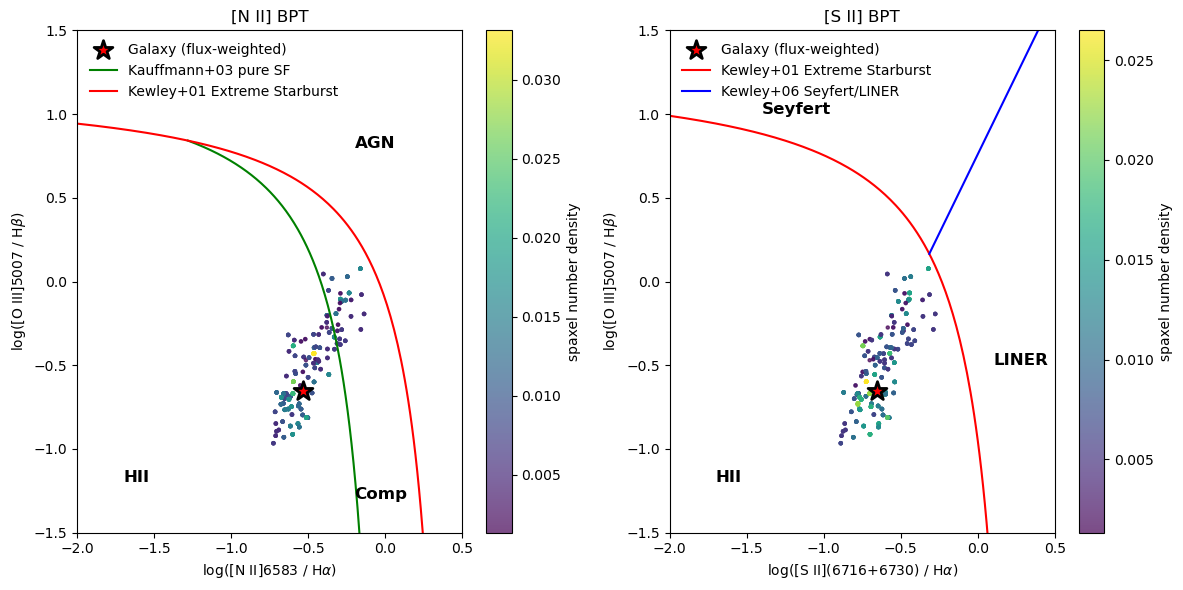

Galaxy flux-weighted representative points:
[N II] BPT: logN2 = -0.535, logO3 = -0.651
[S II] BPT: logS2 = -0.656, logO3 = -0.651
Number of spaxels in [N II] BPT regions:
HII: 24964, Comp: 18537, AGN: 38568
Number of spaxels in [S II] BPT regions:
HII: 35249, Seyfert: 21591, LINER: 16269


In [ ]:
#  N II BPT -----------------------------------------
def kewley01_N2(x):   # max-starburst
    return 0.61/(x-0.47) + 1.19
def kauff03_N2(x):    # empirical SF upper envelope
    return 0.61/(x-0.05) + 1.30                            

#  S II BPT -----------------------------------------
def kewley01_S2(x):
    return 0.72/(x-0.32) + 1.30                           
def kewley06_Sy_LIN(x):   # Seyfert/LINER division
    return 1.89*x + 0.76        

# Calculate flux-weighted galaxy representative points
# Assuming you have a flux array (replace 'flux' with your actual flux variable name)
# If you don't have flux, you can use Ha_flux or another appropriate flux measurement
valid_mask_N2 = np.isfinite(logN2_cut) & np.isfinite(logO3_cut) 
valid_mask_S2 = np.isfinite(logS2_cut) & np.isfinite(logO3_cut) 

# Calculate flux-weighted representative points
galaxy_logN2 = np.log10(np.nansum(10**logN2_cut[valid_mask_N2] * 10**logN2_cut[valid_mask_N2]) / np.nansum(10**logN2_cut[valid_mask_N2]))
galaxy_logO3_N2 = np.log10(np.nansum(10**logO3_cut[valid_mask_N2] * 10**logO3_cut[valid_mask_N2]) / np.nansum(10**logO3_cut[valid_mask_N2]))
galaxy_logS2 = np.log10(np.nansum(10**logS2_cut[valid_mask_S2] * 10**logS2_cut[valid_mask_S2]) / np.nansum(10**logS2_cut[valid_mask_S2]))
galaxy_logO3_S2 = np.log10(np.nansum(10**logO3_cut[valid_mask_S2] * 10**logO3_cut[valid_mask_S2]) / np.nansum(10**logO3_cut[valid_mask_S2]))

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# --- NII BPT -------------------------------------------------------
x = logN2_cut; y = logO3_cut
# Create a 2D histogram to get density information
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
# Assign density values to each point
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[0].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[0], label='spaxel number density')

# Add flux-weighted galaxy point
ax[0].scatter(galaxy_logN2, galaxy_logO3_N2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

xg = np.linspace((286-np.sqrt(2871561))/1100, 0.0, 200)
ax[0].plot(xg, kauff03_N2(xg), 'g-', lw=1.5, label='Kauffmann+03 pure SF')
xr = np.linspace(-2.0, 0.3, 200)
ax[0].plot(xr, kewley01_N2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
ax[0].set_xlabel(r'log([N II]6583 / H$\alpha$)')
ax[0].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[0].set_xlim(-2.0, 0.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_title('[N II] BPT')
ax[0].legend(frameon=False, loc='upper left')

# Add annotations for NII BPT
ax[0].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[0].text(-0.2, -1.3, 'Comp', fontsize=12, fontweight='bold')
ax[0].text(-0.2, 0.8, 'AGN', fontsize=12, fontweight='bold')

# --- SII BPT -------------------------------------------------------
x = logS2_cut; y = logO3_cut
# Create a 2D histogram for S II BPT
valid_mask = np.isfinite(x) & np.isfinite(y)
x_valid = x[valid_mask]
y_valid = y[valid_mask]

h, xedges, yedges = np.histogram2d(x_valid, y_valid, bins=100)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
density = np.zeros_like(x_valid)

for i, (xi, yi) in enumerate(zip(x_valid, y_valid)):
    x_idx = np.argmin(np.abs(x_centers - xi))
    y_idx = np.argmin(np.abs(y_centers - yi))
    density[i] = h[x_idx, y_idx] / len(x_valid)  # Normalize by the number of valid points

scatter = ax[1].scatter(x_valid, y_valid, s=5, c=density, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, ax=ax[1], label='spaxel number density')

# Add flux-weighted galaxy point
ax[1].scatter(galaxy_logS2, galaxy_logO3_S2, s=200, marker='*', c='red', 
              edgecolors='black', linewidth=2, label='Galaxy (flux-weighted)', zorder=10)

ax[1].plot(xr, kewley01_S2(xr), 'r-', lw=1.5, label='Kewley+01 Extreme Starburst')
xb = np.linspace((159-np.sqrt(105081))/525, 0.5, 200)
ax[1].plot(xb, kewley06_Sy_LIN(xb), 'b-', lw=1.5, label='Kewley+06 Seyfert/LINER')
ax[1].set_xlabel(r'log([S II](6716+6730) / H$\alpha$)')
ax[1].set_ylabel(r'log([O III]5007 / H$\beta$)')
ax[1].set_xlim(-2.0, 0.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_title('[S II] BPT')
ax[1].legend(frameon=False)

# Add annotations for SII BPT
ax[1].text(-1.7, -1.2, 'HII', fontsize=12, fontweight='bold')
ax[1].text(-1.4, 1.0, 'Seyfert', fontsize=12, fontweight='bold')
ax[1].text(0.1, -0.5, 'LINER', fontsize=12, fontweight='bold')

plt.tight_layout(); plt.show()

# Print galaxy representative points
print(f"Galaxy flux-weighted representative points:")
print(f"[N II] BPT: logN2 = {galaxy_logN2:.3f}, logO3 = {galaxy_logO3_N2:.3f}")
print(f"[S II] BPT: logS2 = {galaxy_logS2:.3f}, logO3 = {galaxy_logO3_S2:.3f}")

# Count the number of spaxels in each region
N2_HII = logO3 <= kauff03_N2(logN2)
N2_Comp = (logO3 > kauff03_N2(logN2)) & (logO3 <= kewley01_N2(logN2))
N2_AGN = logO3 > kewley01_N2(logN2)
S2_HII = logO3 <= kewley01_S2(logS2)
S2_Seyfert = (logO3 > kewley01_S2(logS2)) & (logO3 > kewley06_Sy_LIN(logS2))
S2_LINER = (logO3 > kewley01_S2(logS2)) & (logO3 <= kewley06_Sy_LIN(logS2))
# Count the number of spaxels in each region
N2_HII_count = np.sum(N2_HII)
N2_Comp_count = np.sum(N2_Comp)
N2_AGN_count = np.sum(N2_AGN)
S2_HII_count = np.sum(S2_HII)
S2_Seyfert_count = np.sum(S2_Seyfert)
S2_LINER_count = np.sum(S2_LINER)
print(f"Number of spaxels in [N II] BPT regions:")
print(f"HII: {N2_HII_count}, Comp: {N2_Comp_count}, AGN: {N2_AGN_count}")
print(f"Number of spaxels in [S II] BPT regions:")
print(f"HII: {S2_HII_count}, Seyfert: {S2_Seyfert_count}, LINER: {S2_LINER_count}")

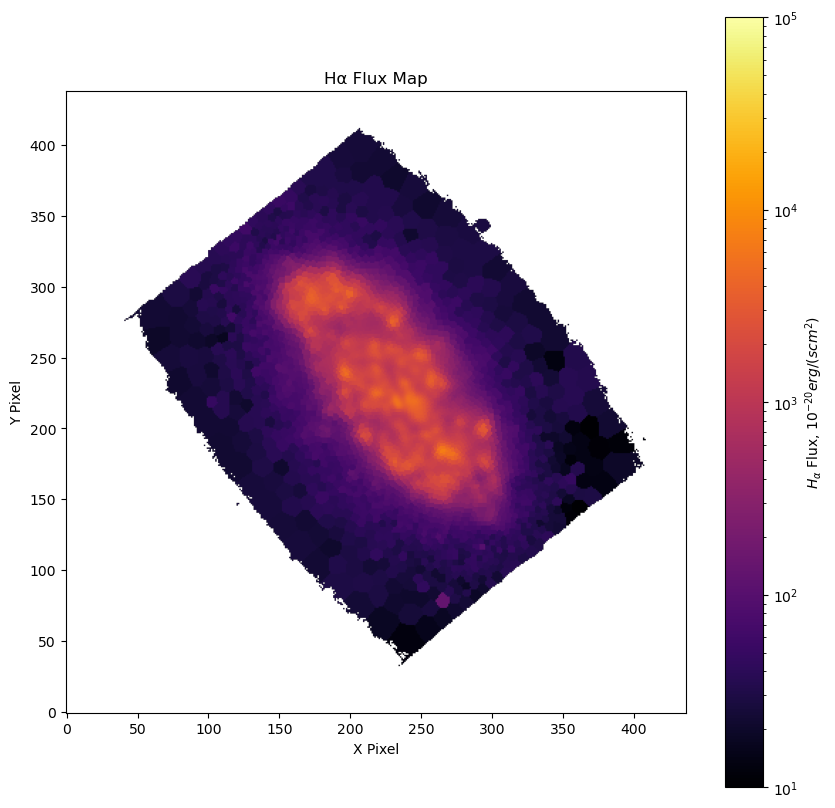

In [13]:
# Plot the Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=1e5))  # Logarithmic normalization
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

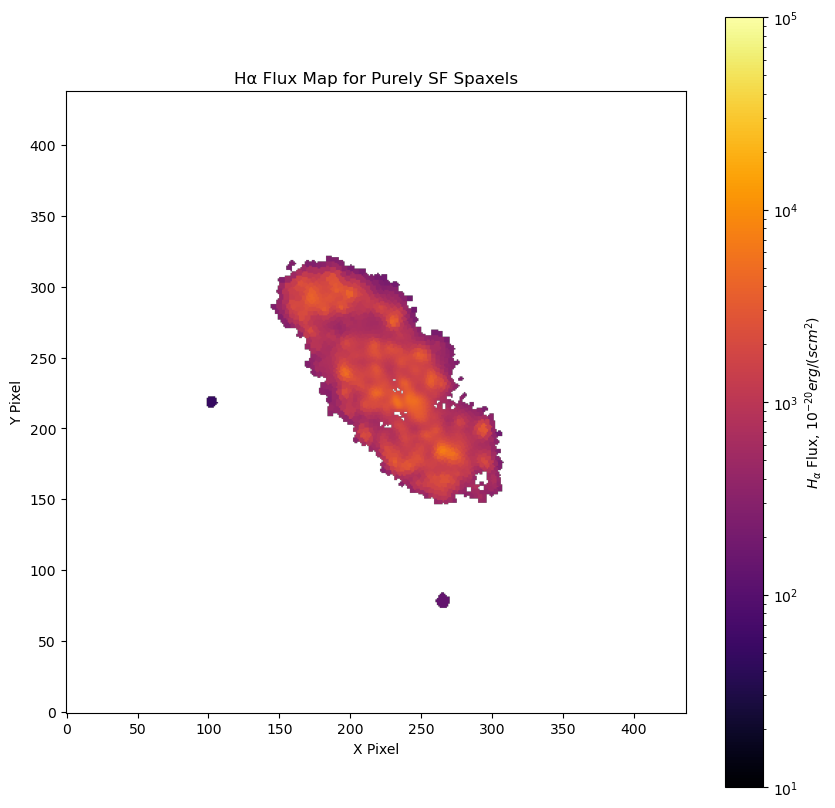

In [14]:
# Purely SF spaxels in both BPT diagram
mask_SF = (N2_HII+N2_Comp) & (S2_HII)
# Apply the mask to the Halpha flux map
HA6562_FLUX_SF = np.where(mask_SF, HA6562_FLUX_cut, np.nan)
# Plot the Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$')
plt.title('Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

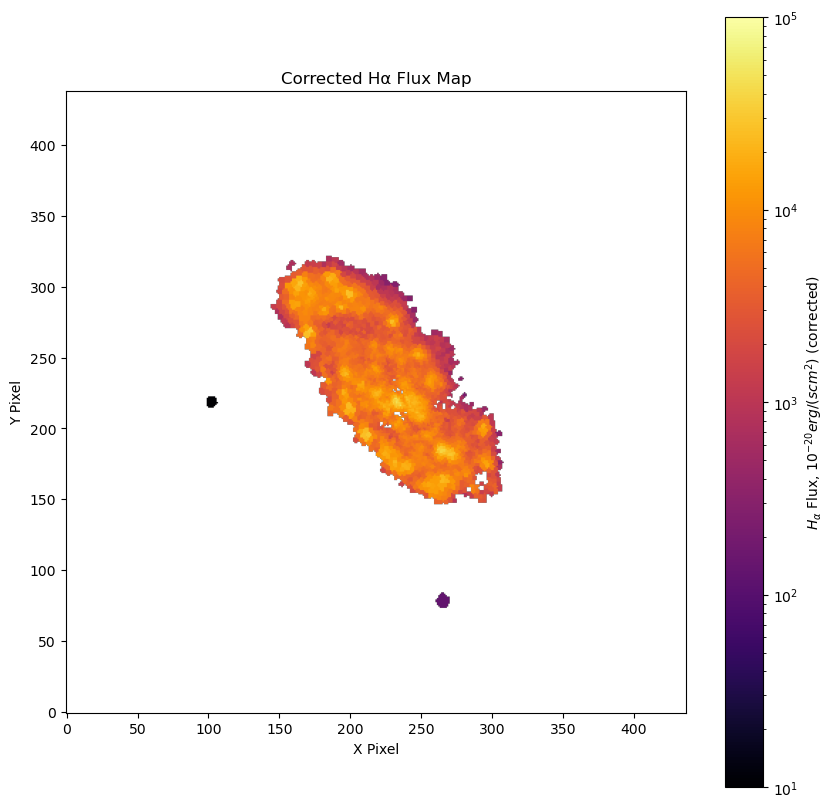

In [15]:
# Corrected Halpha map with E(B-V) from gas lines
HA6562_FLUX_corr = HA6562_FLUX_cut * 10**(0.4 * k_Ha * E_BV_BD)
# Plot the corrected Halpha map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$ (corrected)')
plt.title('Corrected Hα Flux Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

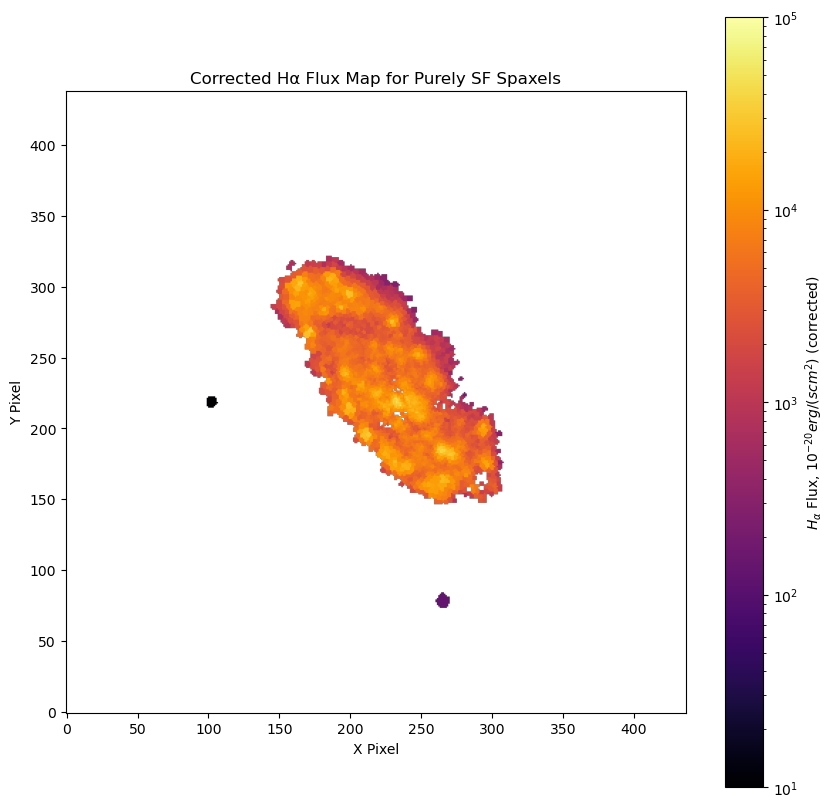

In [16]:
HA6562_FLUX_SF_corr = HA6562_FLUX_SF * 10**(0.4 * k_Ha * E_BV_BD)
# Plot the corrected Halpha map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_FLUX_SF_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=10, vmax=100000))
plt.colorbar(label=r'$H_\alpha$ Flux, $10^{-20}erg/(s cm^2)$ (corrected)')
plt.title('Corrected Hα Flux Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

Total corrected Hα Luminosity: 3.17e+40 erg / s erg/s
Total Hα Luminosity: 7.42e+39 erg / s 
Total corrected Hα Luminosity for purely SF spaxels: 3.17e+40 erg / s 
Total corrected log Hα Luminosity: 6.92 L_sun
Total corrected log Hα Luminosity for purely SF spaxels: 6.92 L_sun


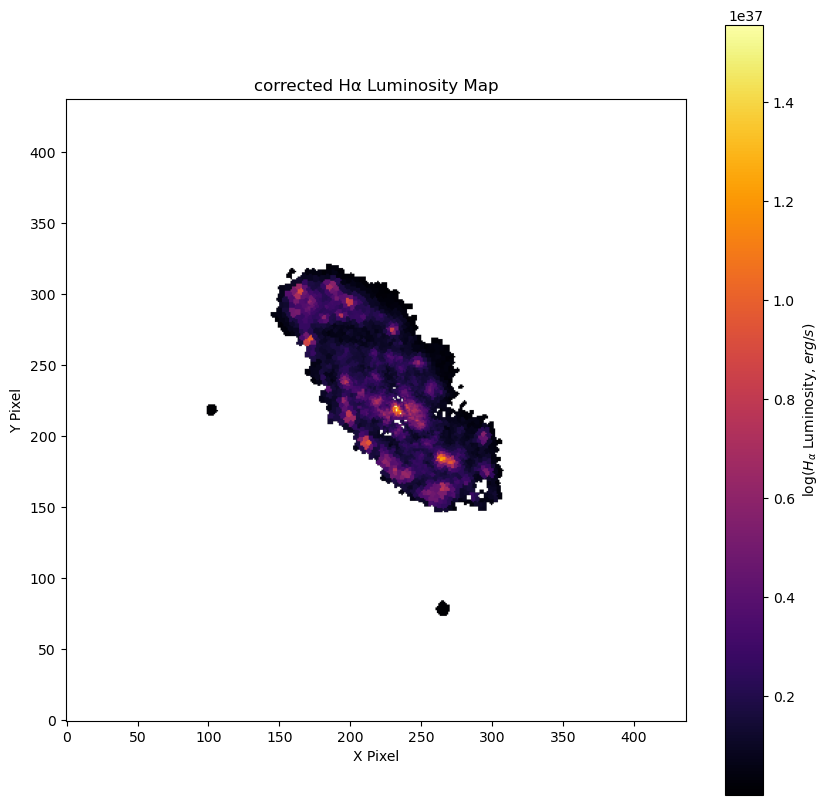

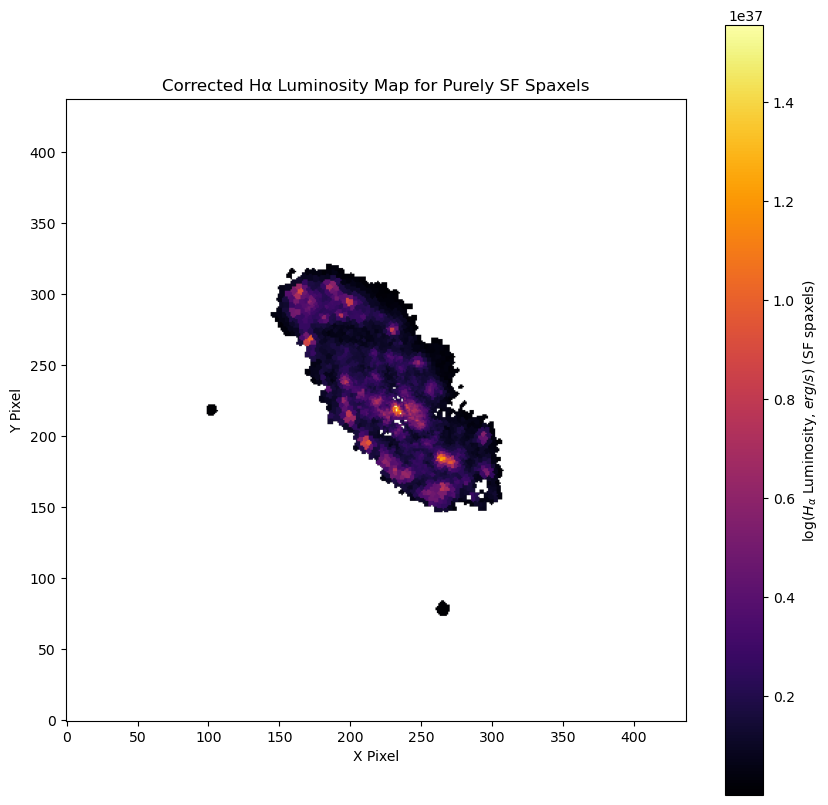

In [17]:
# Convert the corrected Halpha map ($10^{-20}erg/(s cm^2)$) to luminosity (erg/s)
def flux_to_luminosity(flux, distance=16.5):
    """
    Convert flux to luminosity.
    
    Parameters:
    flux : array-like
        Flux in erg/(s * Angstrom * cm^2).
    distance : float
        Distance in parsecs.
        
    Returns:
    luminosity : array-like
        Luminosity in erg/s.
    """
    return (flux*1e-20*u.erg/u.s/u.cm**2 * 4*np.pi*(distance*u.Mpc)**2).cgs

HA6562_Luminosity_corr = flux_to_luminosity(HA6562_FLUX_corr)
HA6562_Luminosity = flux_to_luminosity(HA6562_FLUX)
HA6562_Luminosity_SF_corr = flux_to_luminosity(HA6562_FLUX_SF_corr)
total_HA6562_Luminosity_corr = np.nansum(HA6562_Luminosity_corr)
total_HA6562_Luminosity = np.nansum(HA6562_Luminosity)
total_HA6562_Luminosity_SF_corr = np.nansum(HA6562_Luminosity_SF_corr)
log_halpha_corr = np.log10(HA6562_Luminosity_corr/c.L_sun.cgs)
total_log_halpha_corr = np.log10(total_HA6562_Luminosity_corr/c.L_sun.cgs)
total_log_halpha_SF_corr = np.log10(total_HA6562_Luminosity_SF_corr/c.L_sun.cgs)
print(f"Total corrected Hα Luminosity: {total_HA6562_Luminosity_corr:.2e} erg/s")
print(f"Total Hα Luminosity: {total_HA6562_Luminosity:.2e} ")
print(f"Total corrected Hα Luminosity for purely SF spaxels: {total_HA6562_Luminosity_SF_corr:.2e} ")
print(f"Total corrected log Hα Luminosity: {total_log_halpha_corr:.2f} L_sun")
print(f"Total corrected log Hα Luminosity for purely SF spaxels: {total_log_halpha_SF_corr:.2f} L_sun")
# Plot the corrected Halpha luminosity map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_Luminosity_corr , origin='lower', cmap='inferno')
plt.colorbar(label=r'log($H_\alpha$ Luminosity, $erg/s$)')
plt.title('corrected Hα Luminosity Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()
# Plot the corrected Halpha luminosity map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_Luminosity_SF_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'log($H_\alpha$ Luminosity, $erg/s$) (SF spaxels)')
plt.title('Corrected Hα Luminosity Map for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [18]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   gas_header    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    HA6562_Luminosity_SF_corr_hdu = fits.ImageHDU(
        data=HA6562_Luminosity_SF_corr.value.astype(np.float64),  # like others
        header=gas_header, name="Halpha_Luminosity_SF_corr")  # new HDU name
    HA6562_Luminosity_SF_corr_hdu.header["BUNIT"] = "erg/s"  # units keyword
    hdul.append(HA6562_Luminosity_SF_corr_hdu)                                    # add as 10-th HDU 
    hdul.flush()                                             # write in-place
print("Corrected Halpha luminosity from SF layer saved ➜", out_path.resolve())

Corrected Halpha luminosity from SF layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_gas_BIN_maps_extended.fits


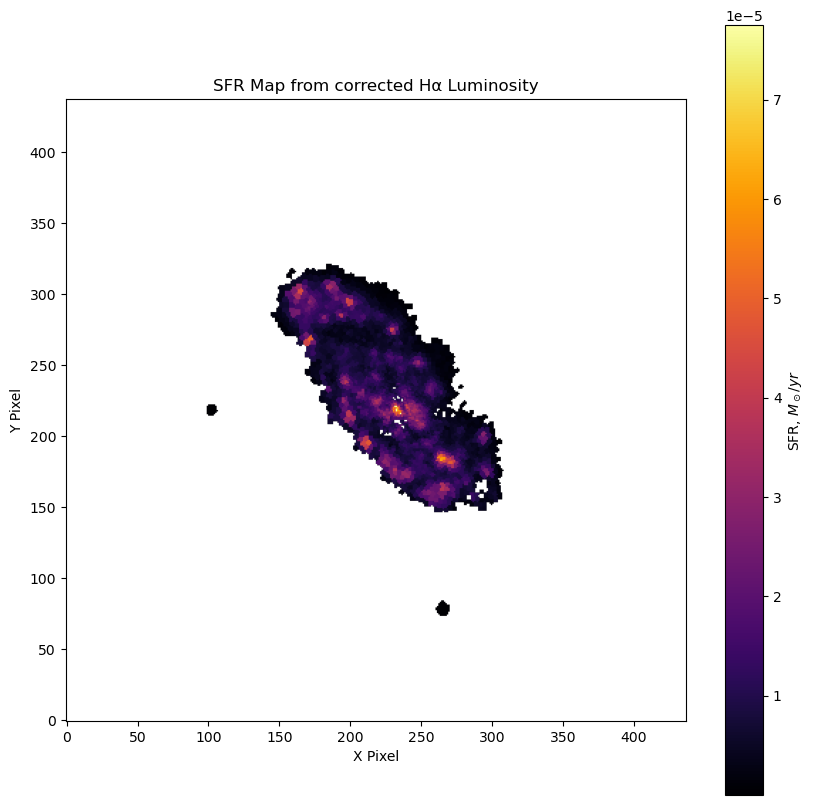

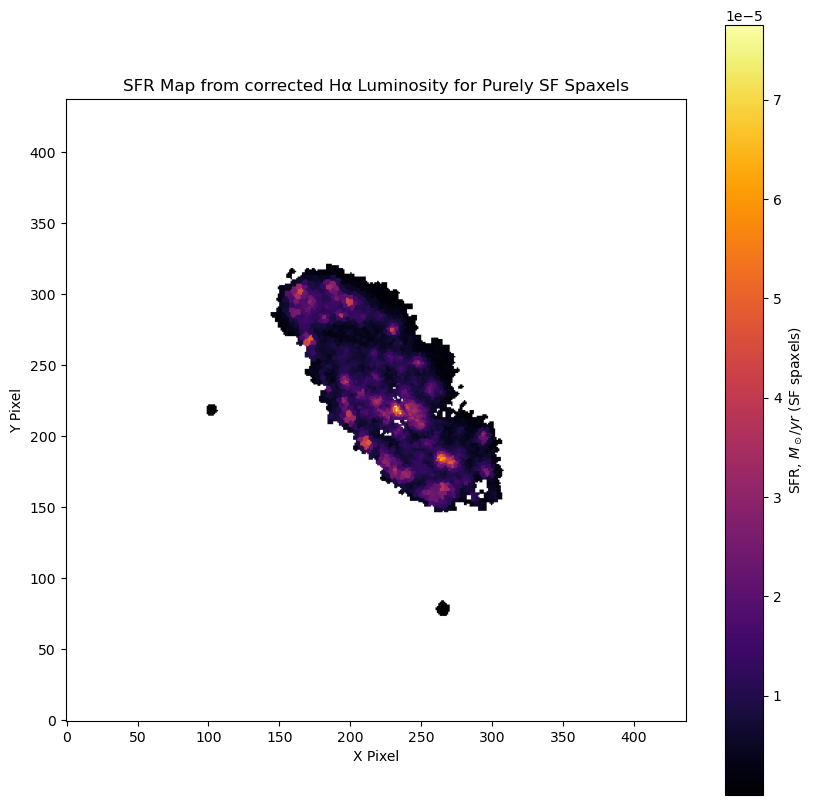

Total SFR from corrected Hα Luminosity: 0.16 M_sun/yr or log(SFR) = -0.80 M_sun/yr
Total SFR from corrected Hα Luminosity for purely SF spaxels: 0.16 M_sun/yr or log(SFR) = -0.80 M_sun/yr


In [19]:
# SFR map from Halpha luminosity, using Calzetti 2007
def calzetti_sfr(luminosity):
    """
    Convert Halpha luminosity to SFR using Calzetti 2007.
    But it is assuming the Kroupa IMF, 
    so we need to times a coefficient to go to Chabrier IMF.
    
    Parameters:
    luminosity : array-like
        Halpha luminosity in erg/s.
        
    Returns:
    sfr : array-like
        Star formation rate in solar masses per year.
    """
    return 5.3e-42 * luminosity.cgs.value / 0.67 *0.63 # SFR in M_sun/yr
HA6562_SFR_corr = calzetti_sfr(HA6562_Luminosity_corr)
total_HA6562_SFR_corr = calzetti_sfr(total_HA6562_Luminosity_corr)
HA6562_SFR_SF_corr = calzetti_sfr(HA6562_Luminosity_SF_corr)
total_HA6562_SFR_SF_corr = calzetti_sfr(total_HA6562_Luminosity_SF_corr)

# Plot the SFR map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'SFR, $M_\odot/yr$')
plt.title('SFR Map from corrected Hα Luminosity')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()
# Plot the SFR map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_SF_corr, origin='lower', cmap='inferno')
plt.colorbar(label=r'SFR, $M_\odot/yr$ (SF spaxels)')
plt.title('SFR Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Print the total SFR in the map
print(f"Total SFR from corrected Hα Luminosity: {total_HA6562_SFR_corr:.2f} M_sun/yr or log(SFR) = {np.log10(total_HA6562_SFR_corr):.2f} M_sun/yr")
print(f"Total SFR from corrected Hα Luminosity for purely SF spaxels: {total_HA6562_SFR_SF_corr:.2f} M_sun/yr or log(SFR) = {np.log10(total_HA6562_SFR_SF_corr):.2f} M_sun/yr")

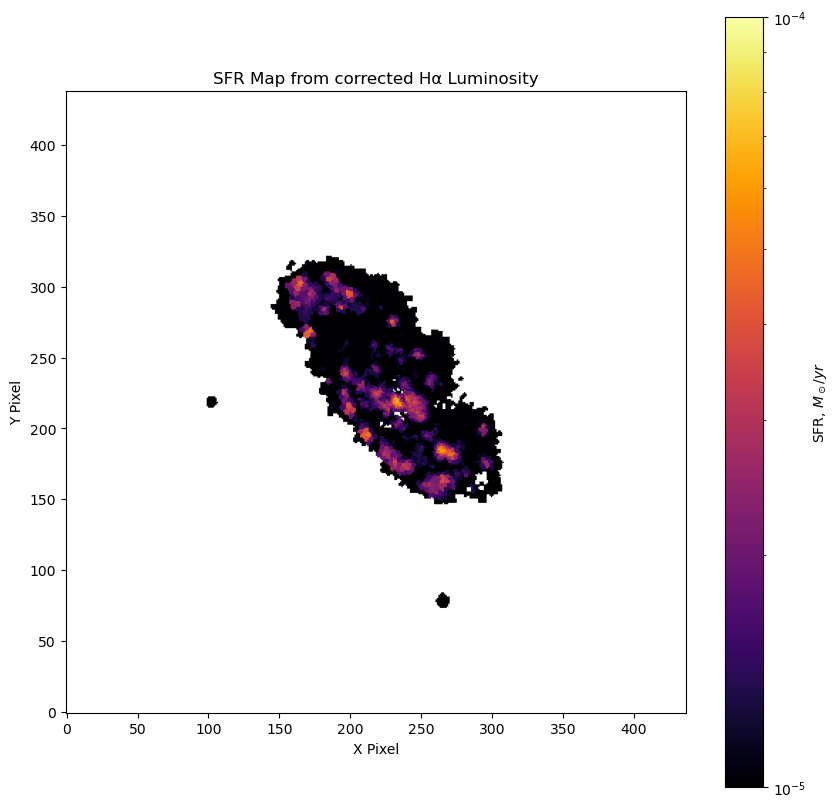

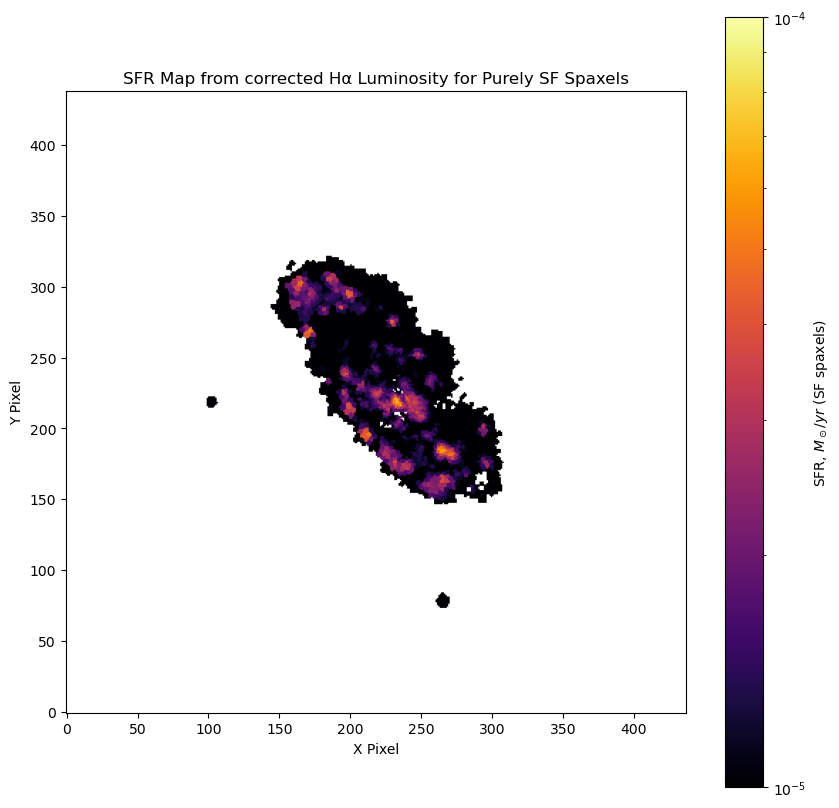

In [20]:
# Plot the SFR map
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=1e-5, vmax=1e-4))  
plt.colorbar(label=r'SFR, $M_\odot/yr$')
plt.title('SFR Map from corrected Hα Luminosity')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

# Plot the SFR map for purely SF spaxels
plt.figure(figsize=(10, 10))
plt.imshow(HA6562_SFR_SF_corr, origin='lower', cmap='inferno', 
           norm=LogNorm(vmin=1e-5, vmax=1e-4))
plt.colorbar(label=r'SFR, $M_\odot/yr$ (SF spaxels)')
plt.title('SFR Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [21]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   gas_header    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    HA6562_SFR_SF_corr_hdu = fits.ImageHDU(
        data=HA6562_SFR_SF_corr.astype(np.float64),  # like others
        header=gas_header, name="Halpha_SFR_SF_corr")  # new HDU name
    HA6562_SFR_SF_corr_hdu.header["BUNIT"] = "M_sun/yr"  # units keyword
    hdul.append(HA6562_SFR_SF_corr_hdu)                                    # add as 10-th HDU 
    hdul.flush()                                             # write in-place
print("Corrected Halpha SFR from SF layer saved ➜", out_path.resolve())

Corrected Halpha SFR from SF layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_gas_BIN_maps_extended.fits


In [22]:
np.nansum(HA6562_FLUX_cut*1e-20*u.erg/u.s/u.cm**2), np.nansum(HA6562_FLUX_corr*1e-20*u.erg/u.s/u.cm**2), np.nansum(HA6562_FLUX_SF*1e-20*u.erg/u.s/u.cm**2), np.nansum(HA6562_FLUX_SF_corr*1e-20*u.erg/u.s/u.cm**2)

(<Quantity 1.97753244e-13 erg / (s cm2)>,
 <Quantity 9.730115e-13 erg / (s cm2)>,
 <Quantity 1.97753244e-13 erg / (s cm2)>,
 <Quantity 9.730115e-13 erg / (s cm2)>)

In [23]:
np.log10(np.nansum(HA6562_FLUX_cut*1e-20*u.erg/u.s/u.cm**2).value), np.log10(np.nansum(HA6562_FLUX_corr*1e-20*u.erg/u.s/u.cm**2).value), np.log10(np.nansum(HA6562_FLUX_SF*1e-20*u.erg/u.s/u.cm**2).value), np.log10(np.nansum(HA6562_FLUX_SF_corr*1e-20*u.erg/u.s/u.cm**2).value)

(np.float64(-12.703876382859002),
 np.float64(-12.01188202657726),
 np.float64(-12.703876382859002),
 np.float64(-12.01188202657726))

In [24]:
np.nansum(HA6562_FLUX*1e-20*u.erg/u.s/u.cm**2).cgs.value, np.log10(np.nansum(HA6562_FLUX*1e-20*u.erg/u.s/u.cm**2).cgs.value)

(np.float64(2.2781398244676964e-13), np.float64(-12.642419623921901))

In [25]:
print(f"{np.nansum(HA6562_FLUX):.4e}")

2.2781e+07


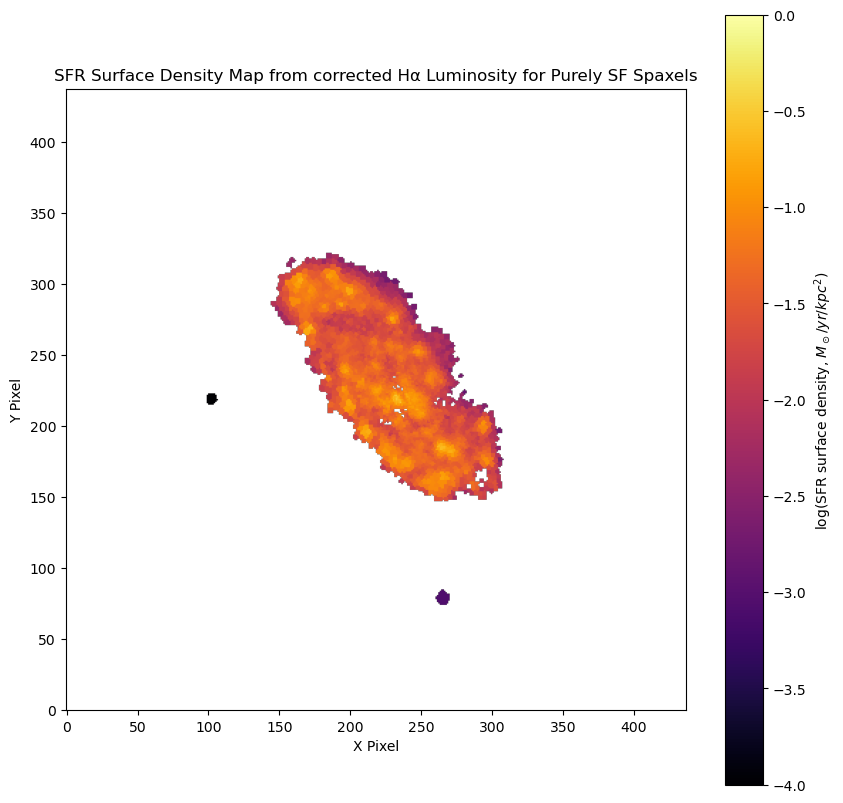

In [26]:
# Getting the SFR surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(gas_header).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert SFR to surface density
SFR_surface_density = HA6562_SFR_SF_corr / pixel_area_kpc  # M☉/yr/kpc²
# 3. Convert to log10 scale
log_SFR_surface_density = np.log10(SFR_surface_density.value)

# Plot the SFR surface density map
plt.figure(figsize=(10, 10))
plt.imshow(log_SFR_surface_density, origin='lower', cmap='inferno', 
           vmin=-4, vmax=0)  # Logarithmic normalization
plt.colorbar(label=r'log(SFR surface density, $M_\odot/yr/kpc^2$)')
plt.title('SFR Surface Density Map from corrected Hα Luminosity for Purely SF Spaxels')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [27]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   gas_header    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    log_SFR_surface_density_hdu = fits.ImageHDU(
        data=log_SFR_surface_density.astype(np.float64),  # like others
        header=gas_header, name="LOGSFR_SURFACE_DENSITY")  # new HDU name
    log_SFR_surface_density_hdu.header["BUNIT"] = "log(M_sun/yr/kpc2)"  # units keyword
    hdul.append(log_SFR_surface_density_hdu)                                    # add as 10-th HDU 
    hdul.flush()                                             # write in-place
print("Corrected Halpha SFR surface density from SF layer saved ➜", out_path.resolve())

Corrected Halpha SFR surface density from SF layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_gas_BIN_maps_extended.fits
